In [22]:
from wrf import getvar, ALL_TIMES
from glob import glob
from netCDF4 import Dataset as nc

import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.cm import get_cmap
import matplotlib.transforms as mtransforms
from matplotlib.offsetbox import AnchoredText

import matplotlib.colors as mcolors
import cartopy.crs as ccrs
import cartopy.feature as cfeature

from wrf import (to_np, getvar, smooth2d, get_cartopy, cartopy_xlim,
                 cartopy_ylim, latlon_coords, vinterp, ll_to_xy, interplevel)

from metpy.plots import USCOUNTIES
from metpy.units import units

In [2]:
### define a scalebar, from https://stackoverflow.com/a/41600150/13836965

from math import floor
from matplotlib import patheffects

def utm_from_lon(lon):
    """
    utm_from_lon - UTM zone for a longitude

    Not right for some polar regions (Norway, Svalbard, Antartica)

    :param float lon: longitude
    :return: UTM zone number
    :rtype: int
    """
    return floor( ( lon + 180 ) / 6) + 1

def scale_bar(ax, proj, length, location=(0.5, 0.05), linewidth=3,
              units='km', m_per_unit=1000):
    """

    http://stackoverflow.com/a/35705477/1072212
    ax is the axes to draw the scalebar on.
    proj is the projection the axes are in
    location is center of the scalebar in axis coordinates ie. 0.5 is the middle of the plot
    length is the length of the scalebar in km.
    linewidth is the thickness of the scalebar.
    units is the name of the unit
    m_per_unit is the number of meters in a unit
    """
    # find lat/lon center to find best UTM zone
    x0, x1, y0, y1 = ax.get_extent(proj.as_geodetic())
    # Projection in metres
    utm = crs.UTM(utm_from_lon((x0+x1)/2))
    # Get the extent of the plotted area in coordinates in metres
    x0, x1, y0, y1 = ax.get_extent(utm)
    # Turn the specified scalebar location into coordinates in metres
    sbcx, sbcy = x0 + (x1 - x0) * location[0], y0 + (y1 - y0) * location[1]
    # Generate the x coordinate for the ends of the scalebar
    bar_xs = [sbcx - length * m_per_unit/2, sbcx + length * m_per_unit/2]
    # buffer for scalebar
    buffer = [patheffects.withStroke(linewidth=5, foreground="w")]
    # Plot the scalebar with buffer
    ax.plot(bar_xs, [sbcy, sbcy], transform=utm, color='k',
        linewidth=linewidth, path_effects=buffer)
    # buffer for text
    buffer = [patheffects.withStroke(linewidth=3, foreground="w")]
    # Plot the scalebar label
    t0 = ax.text(sbcx, sbcy, str(length) + ' ' + units, transform=utm,
        horizontalalignment='center', verticalalignment='bottom',
        path_effects=buffer, zorder=2)
    left = x0+(x1-x0)*0.05
    # Plot the N arrow
    #t1 = ax.text(left, sbcy, u'\u25B2\nN', transform=utm,
    #    horizontalalignment='center', verticalalignment='bottom',
    #    path_effects=buffer, zorder=2)
    # Plot the scalebar without buffer, in case covered by text buffer
    ax.plot(bar_xs, [sbcy, sbcy], transform=utm, color='k',
        linewidth=linewidth, zorder=3)


### 1-minute ASOS obs

In [11]:
######## get data and prep

#### 1-minute asos
asos = pd.read_csv("https://mesonet.agron.iastate.edu/cgi-bin/request/asos1min.py?station=AKO&station=CYS&station=SNY&station=LIC&station=DEN&station=LAR&station=APA&station=TOR&station=BFF&station=AIA&station=DGW&station=CPR&tz=UTC&year1=2022&month1=12&day1=21&hour1=0&minute1=0&year2=2022&month2=12&day2=23&hour2=22&minute2=0&vars=pres1&sample=1min&what=download&delim=comma&gis=yes",
                   parse_dates=['valid(UTC)'])
    
asos['datetime'] = asos['valid(UTC)'].dt.tz_localize("UTC")
asos.set_index("datetime", inplace=True)

asos['pres1'] = pd.to_numeric(asos['pres1'], errors='coerce')
asos['pres1_hPa'] = asos['pres1']*units('inHg').to("hPa")


In [12]:
### set a multi-index to allow for stacking/unstacking
asos.set_index([asos.index,"station"],inplace=True)

In [13]:
### calculate shifts

asos['shifted_1min'] = asos.unstack().shift(1, freq='min').stack()['pres1_hPa']
asos['shifted_2min'] = asos.unstack().shift(2, freq='min').stack()['pres1_hPa']
asos['shifted_5min'] = asos.unstack().shift(5, freq='min').stack()['pres1_hPa']
asos['shifted_10min'] = asos.unstack().shift(10, freq='min').stack()['pres1_hPa']
asos['shifted_15min'] = asos.unstack().shift(15, freq='min').stack()['pres1_hPa']
asos['shifted_30min'] = asos.unstack().shift(30, freq='min').stack()['pres1_hPa']
asos['shifted_60min'] = asos.unstack().shift(60, freq='min').stack()['pres1_hPa']
asos['shifted_120min'] = asos.unstack().shift(120, freq='min').stack()['pres1_hPa']
asos['shifted_180min'] = asos.unstack().shift(180, freq='min').stack()['pres1_hPa']

asos['Tchange_1min'] = asos['shifted_1min'] - asos['pres1_hPa']
asos['Tchange_2min'] = asos['shifted_2min'] - asos['pres1_hPa']
asos['Tchange_5min'] = asos['shifted_5min'] - asos['pres1_hPa']
asos['Tchange_10min'] = asos['shifted_10min'] - asos['pres1_hPa']
asos['Tchange_15min'] = asos['shifted_15min'] - asos['pres1_hPa']
asos['Tchange_30min'] = asos['shifted_30min'] - asos['pres1_hPa']
asos['Tchange_60min'] = asos['shifted_60min'] - asos['pres1_hPa']
asos['Tchange_120min'] = asos['shifted_120min'] - asos['pres1_hPa']
asos['Tchange_180min'] = asos['shifted_180min'] - asos['pres1_hPa']

### and reset index
asos = asos.reset_index().set_index('datetime').sort_index()

/tmp/ipykernel_2439197/1681845300.py:3: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  asos['shifted_1min'] = asos.unstack().shift(1, freq='min').stack()['pres1_hPa']
/tmp/ipykernel_2439197/1681845300.py:4: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  asos['shifted_2min'] = asos.unstack().shift(2, freq='min').stack()['pres1_hPa']
/tmp/ipykernel_2439197/1681845300.py:5: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to ado

In [14]:
asos

,station,station_name,lat,lon,valid(UTC),pres1,pres1_hPa,shifted_1min,shifted_2min,shifted_5min,...,shifted_180min,Tchange_1min,Tchange_2min,Tchange_5min,Tchange_10min,Tchange_15min,Tchange_30min,Tchange_60min,Tchange_120min,Tchange_180min
datetime,,,,,,,,,,,,,,,,,,,,,
2022-12-21 00:00:00+00:00,AIA,ALLIANCE,42.0572,-102.8000,2022-12-21 00:00:00,26.148,885.472902,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-12-21 00:00:00+00:00,CPR,CASPER/NATRONA INTL,42.9080,-106.4644,2022-12-21 00:00:00,24.639,834.372297,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-12-21 00:00:00+00:00,APA,DENVER/CENTENNIAL,39.5700,-104.8500,2022-12-21 00:00:00,24.262,821.605612,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-12-21 00:00:00+00:00,CYS,CHEYENNE/WARREN AFB,41.1556,-104.8105,2022-12-21 00:00:00,24.004,812.868729,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-12-21 00:00:00+00:00,DEN,DENVER INTNL ARPT,39.8328,-104.6575,2022-12-21 00:00:00,24.702,836.505722,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-23 21:59:00+00:00,BFF,SCOTTSBLUFF,41.8740,-103.5956,2022-12-23 21:59:00,26.299,890.586349,890.586349,890.586349,890.552485,...,892.381135,0.000000,0.000000,-0.033864,0.000000,0.101592,0.135456,0.270911,0.948189,1.794786
2022-12-23 21:59:00+00:00,APA,DENVER/CENTENNIAL,39.5700,-104.8500,2022-12-23 21:59:00,24.368,825.195184,825.161320,825.161320,825.127456,...,826.075645,-0.033864,-0.033864,-0.067728,-0.135456,-0.304775,-0.372503,-0.609550,-0.135456,0.880461
2022-12-23 21:59:00+00:00,AKO,AKRON/WASHINGTON CO,40.1756,-103.2220,2022-12-23 21:59:00,25.568,865.831848,865.831848,865.831848,865.865711,...,866.983220,0.000000,0.000000,0.033864,0.000000,0.000000,-0.135456,0.000000,0.304775,1.151372


### now make the plot with the WRF pressure change and ASOS pressure change

working on /schumacher-scratch3/rschumac/flood/ere_cases/WRFV4/2022122118_hrrr_2dom_600m/wrfout_d02_2022-12-21_20:30:00


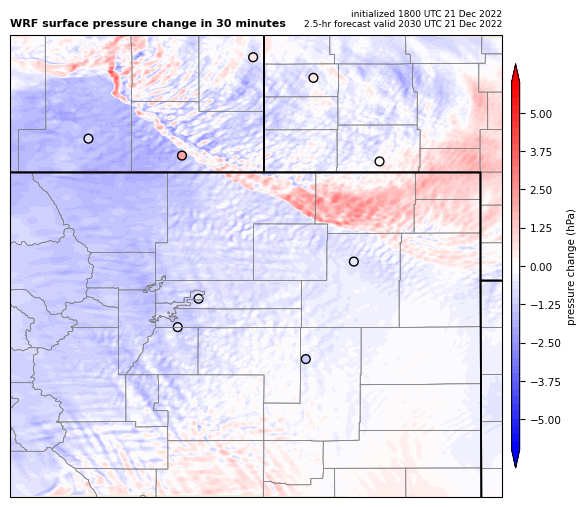

working on /schumacher-scratch3/rschumac/flood/ere_cases/WRFV4/2022122118_hrrr_2dom_600m/wrfout_d02_2022-12-21_23:00:00


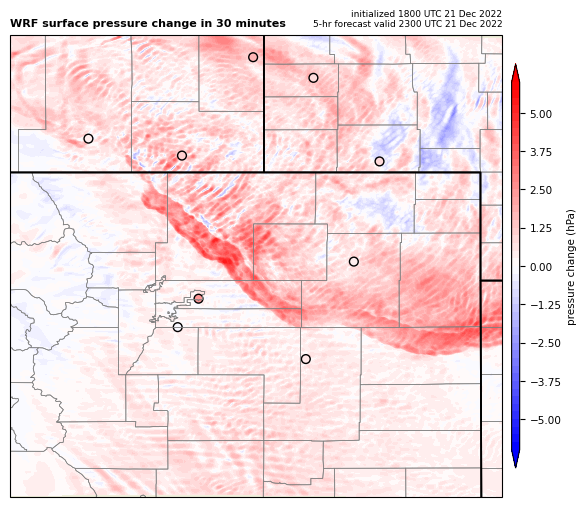

In [17]:
## now we're going to make plots for a series of hours
## define our end hours

init = pd.Timestamp(2022,12,21,18)

#endhrs=['20:00','20:30','21:00','21:30','22:00','22:30','23:00','23:30']
endhrs=['20:30','23:00']
#endhrs=['00:00','00:30','01:00','01:30','02:00','02:30','03:00']

diff_minutes = 30  ##### how many minutes to calculate the difference? 

for endhr in endhrs:
    
    ## get the times we need
    times = pd.date_range(start=pd.Timestamp('2022-12-21 '+str(endhr)) - pd.Timedelta(minutes=diff_minutes), end='2022-12-21 '+str(endhr), 
                          freq=str(diff_minutes)+"min")


    # wrf filenames matching these times
    wrf_filenames = "/schumacher-scratch3/rschumac/flood/ere_cases/WRFV4/2022122118_hrrr_2dom_600m/wrfout_d02_"+times.strftime("%Y-%m-%d_%H:%M:%S") 
    
    ## identify the two files here
    wrf_filename_last = wrf_filenames[-1]
    wrf_filename_first = wrf_filenames[0]
    
    print("working on "+wrf_filename_last)
    
    ## read in some files
    ncfile_last = [nc(wrf_filename_last)]
    ncfile_first = [nc(wrf_filename_first)]
    
    ## read in T2 
    psfc_end = getvar(ncfile_last,"PSFC")
    psfc_start = getvar(ncfile_first,"PSFC")
    
    ## valid time
    vtime = pd.to_datetime(psfc_end.Time.values)
    
    ## what's the lead time (in hours)?
    fcst_lead = np.round((psfc_end.XTIME/60.).values,2)
    ## format this more nicely (removing the decimal if it's the top of the hour)
    fcst_lead_nice = int(fcst_lead.item()) if fcst_lead.item().is_integer() else np.round(fcst_lead.item(),2)
    
    ####### now let's make a map of reflectivity and the surface wind swath
    # Get the latitude and longitude points
    lats, lons = latlon_coords(psfc_end)

    # Get the cartopy mapping object
    #cart_proj = get_cartopy(dbz_1km)
    cart_proj = ccrs.PlateCarree()
    
    # Create a figure
    fig = plt.figure(figsize=(12,6))
    # Set the GeoAxes to the projection used by WRF
    ax = plt.axes(projection=cart_proj)
    
    # Add some various map elements to the plot to make it recognizable.
    ax.add_feature(cfeature.LAND.with_scale('10m'))
    ax.add_feature(USCOUNTIES.with_scale('5m'), edgecolor="gray", linewidth=0.5)
    ax.add_feature(cfeature.STATES.with_scale('10m'),linewidth=1.25)
    ax.add_feature(cfeature.BORDERS.with_scale('10m'))
    
    #ax.set_extent([-106.49114990234375,-101.61444091796875,37.97676467895508,42.27891540527344])
    ax.set_extent([-106.4,-101.85,38.0,42.27])

    cf = ax.contourf(to_np(lons), to_np(lats), to_np((psfc_end - psfc_start)/100.), 
                    np.arange(-6,6.25,0.25),
                       cmap='bwr',
                     extend='both',
                      transform_first=True,
                 transform=ccrs.PlateCarree())
      
    cb = plt.colorbar(cf, orientation='vertical', pad=0.01,
                      shrink=0.875, aspect=50)
    cb.ax.tick_params(labelsize=7.5)
    cb.set_label('pressure change (hPa)', fontsize=7.5)
    #cb.locator = ticker.MaxNLocator(nbins=14)
    #cb.update_ticks()
    
    asos_this = asos.reset_index(drop=False).set_index("datetime")[times[1].strftime("%Y-%m-%d %H:%M"):times[1].strftime("%Y-%m-%d %H:%M")]
    ax.scatter(asos_this['lon'],asos_this['lat'],s=40,
              c=-asos_this["Tchange_"+str(diff_minutes)+"min"],
               cmap='bwr', vmin=-5,vmax=5.25, edgecolors='black',
               transform=ccrs.PlateCarree())
    
    # add titles
    plt.title("WRF surface pressure change in "+str(diff_minutes)+" minutes",
              loc='left', weight='bold', fontsize=8)
    plt.title("initialized "+init.strftime("%H%M UTC %d %b %Y")+"\n"+str(fcst_lead_nice)+"-hr forecast valid "+vtime.strftime("%H%M UTC %d %b %Y"), 
          loc='right', fontsize=6.5)
    
    plt.show()

    fig.savefig("psfc_change_coag_"+str(diff_minutes)+"_"+init.strftime("%Y%m%d%H")+"_"+vtime.strftime("%H%M")+".pdf",
               bbox_inches='tight',dpi=255,transparent=False,facecolor='white')

    plt.close('all')

### make 2-panel version

2022-12-21 20:30:00
working on /schumacher-scratch3/rschumac/flood/ere_cases/WRFV4/2022122118_hrrr_2dom_600m/wrfout_d02_2022-12-21_20:30:00
2022-12-21 23:00:00
working on /schumacher-scratch3/rschumac/flood/ere_cases/WRFV4/2022122118_hrrr_2dom_600m/wrfout_d02_2022-12-21_23:00:00


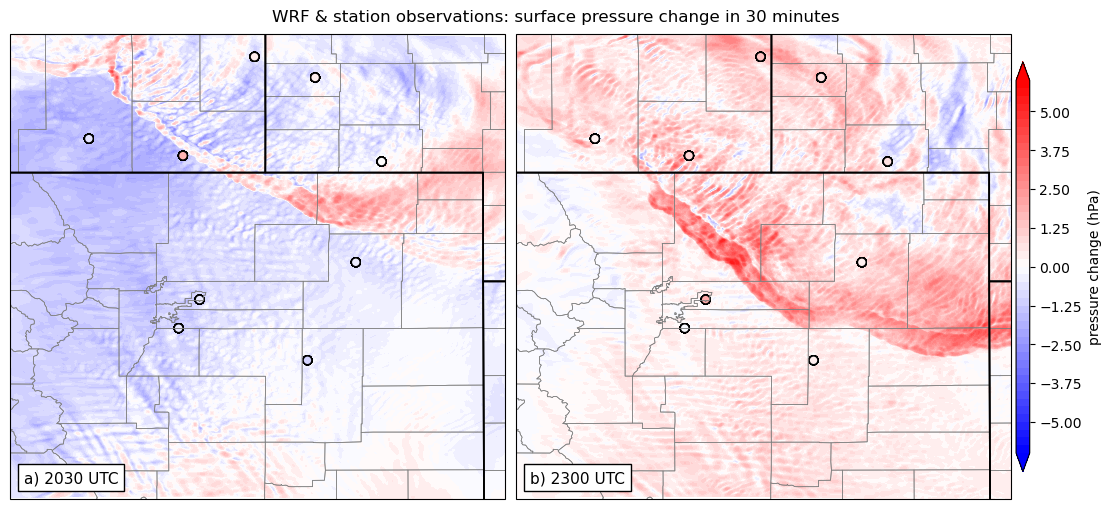

In [24]:
# Get the cartopy mapping object
#cart_proj = get_cartopy(dbz_1km)
cart_proj = ccrs.PlateCarree()

diff_minutes = 30  ##### how many minutes to calculate the difference? 

times = ['20:30','23:00']

panel_names = {'20:30':'a) 2030 UTC', '23:00':'b) 2300 UTC'}

# Plot the raw time series
fig, axs = plt.subplot_mosaic([
    times,
], layout='constrained', figsize=(11,5), subplot_kw={'projection': cart_proj})

for tt in times:

    vtime_str = '2022-12-21 '+tt
    vtime = pd.to_datetime(vtime_str)
    start_time = vtime - pd.Timedelta(minutes=diff_minutes)

    print(vtime)
    
    # wrf filename matching these times
    wrf_filename_end = "/schumacher-scratch3/rschumac/flood/ere_cases/WRFV4/2022122118_hrrr_2dom_600m/wrfout_d02_"+vtime.strftime("%Y-%m-%d_%H:%M:%S") 
    wrf_filename_start = "/schumacher-scratch3/rschumac/flood/ere_cases/WRFV4/2022122118_hrrr_2dom_600m/wrfout_d02_"+start_time.strftime("%Y-%m-%d_%H:%M:%S")    
       
    print("working on "+wrf_filename_end)
    
    ## read in some files
    ncfile_end = [nc(wrf_filename_end)]
    ncfile_start = [nc(wrf_filename_start)]

    ## read in T2 
    psfc_end = getvar(ncfile_end,"PSFC")
    psfc_start = getvar(ncfile_start,"PSFC")
    
    ## what's the lead time (in hours)?
    fcst_lead = np.round((psfc_end.XTIME/60.).values,2)
    ## format this more nicely (removing the decimal if it's the top of the hour)
    fcst_lead_nice = int(fcst_lead.item()) if fcst_lead.item().is_integer() else np.round(fcst_lead.item(),2)
    
    ####### now let's make a map of reflectivity and the surface wind swath
    # Get the latitude and longitude points
    lats, lons = latlon_coords(psfc_end)

    # Add some various map elements to the plot to make it recognizable.
    #axs[tt].add_feature(cfeature.LAND.with_scale('10m'))
    axs[tt].add_feature(USCOUNTIES.with_scale('5m'), edgecolor="gray", linewidth=0.5)
    axs[tt].add_feature(cfeature.STATES.with_scale('10m'),linewidth=1.25)
    axs[tt].add_feature(cfeature.BORDERS.with_scale('10m'))
    
    #ax.set_extent([-106.49114990234375,-101.61444091796875,37.97676467895508,42.27891540527344])
    axs[tt].set_extent([-106.4,-101.85,38.0,42.27])

    cf = axs[tt].contourf(to_np(lons), to_np(lats), to_np((psfc_end - psfc_start)/100.), 
                    np.arange(-6,6.25,0.25),
                           cmap='bwr',
                      #    cmap=RdBu_11_r.mpl_colormap,
                     extend='both',
                      transform_first=True,
                 transform=ccrs.PlateCarree())

    if tt==times[-1]:
        cb = plt.colorbar(cf, orientation='vertical', pad=0.01,
                          shrink=0.875, aspect=30)
        cb.ax.tick_params(labelsize=10)
        cb.set_label('pressure change (hPa)', fontsize=10)
        #cb.locator = ticker.MaxNLocator(nbins=14)
        #cb.update_ticks()

    asos_this = asos.reset_index(drop=False).set_index("datetime")[start_time.strftime("%Y-%m-%d %H:%M"):vtime.strftime("%Y-%m-%d %H:%M")]
    axs[tt].scatter(asos_this['lon'],asos_this['lat'],s=40,
              c=-asos_this["Tchange_"+str(diff_minutes)+"min"],
               cmap='bwr', vmin=-6,vmax=6.25, edgecolors='black',
               transform=ccrs.PlateCarree())

    ### panel label
    text = AnchoredText(panel_names[tt],
                    loc='lower left', prop={'size': 11}, frameon=True, zorder=20)
    axs[tt].add_artist(text)
    
plt.suptitle("WRF & station observations: surface pressure change in 30 minutes", fontsize=12)

# add titles
# plt.title("WRF 2-m temperature change in "+str(diff_minutes)+" minutes",
#           loc='left', weight='bold', fontsize=8)
# plt.title("initialized "+init.strftime("%H%M UTC %d %b %Y")+"\n"+str(fcst_lead_nice)+"-hr forecast valid "+vtime.strftime("%H%M UTC %d %b %Y"), 
#       loc='right', fontsize=6.5)

plt.show()

fig.savefig("psfc_change_coag_"+str(diff_minutes)+"_2panel.pdf",
           bbox_inches='tight',dpi=255,transparent=False,facecolor='white')

plt.close('all')

In [7]:
cart_proj.proj4_params

{'ellps': 'WGS84',
 'a': 6378137.0,
 'proj': 'eqc',
 'lon_0': 0.0,
 'to_meter': 111319.49079327357,
 'vto_meter': 1}

In [10]:
ax.get_extent()

(-106.49114990234375,
 -101.61444091796875,
 37.97676467895508,
 42.27891540527344)

<AxesSubplot:xlabel='Date and Time'>

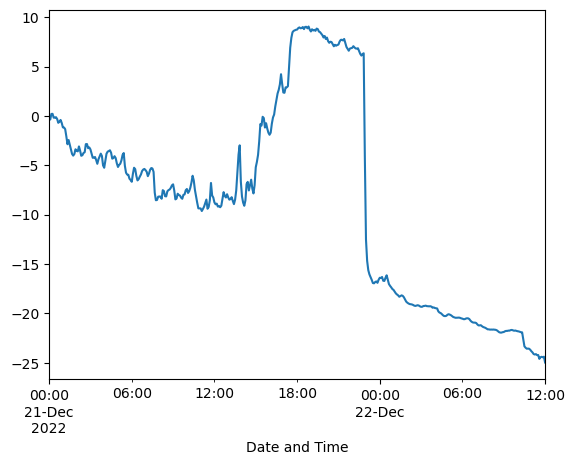

In [24]:
coag_east[coag_east.Station=="fcc01"]['Air Temp'].plot()